# Machine Learning analysis of NYC AirBnb Data

### Description:
This is an analysis used for a a general workshop. This notebook covers data exploration, data pipelines and machine learning analysis. 

# Code

### Import packages

In [40]:
%load_ext autoreload
%autoreload 2
from utils import *
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We set the random seeds for reproducability

In [41]:
np.random.seed(RANDOM_STATE)

### Import data
import data via CSV file into a pandas dataframe

In [42]:
df = importDataCSV('../NYC_AirBnb/NYC_AIRBNB_NanClean.csv')

## (1) Data overview 

In [43]:
print('Number of features: {}'.format(df.shape[1]))
print('Number of observations: {}'.format(df.shape[0]))

Number of features: 29
Number of observations: 50376


In [44]:
df.head(2)

,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,Manhattan,Apartment,Entire home/apt,1,1.000,0.000,1.000,Real Bed,225.000,350.000,95.000,1,0.000,10,1125,10,10,1125,1125,10.000,1125.000,48,9.000,9.000,10.000,10.000,10.000,9.000,0.390
1,Brooklyn,Guest suite,Entire home/apt,3,1.000,1.000,4.000,Real Bed,89.000,500.000,0.000,1,0.000,1,730,1,1,730,730,1.000,730.000,295,9.000,9.000,10.000,9.000,10.000,9.000,4.670


## Pipeline

In [103]:
class Pipeline():
    
    def __init__(self, df_uc):
        """Constructor"""
        #initiate all columns to be dropped
        self.drop_cols = []
        
        #Convert datatypes
        self.df = self.convertDtypes(df_uc)
        
        #Remove observations based on price
        self.df = self.removePriceOutliers(self.df, method='zero')
        
        #Drop based on initial research
        self.dropInitialResearch()
        
        #Split for validation
        self.splitDataset()
        
        #Power transform variables
        self.powerTransform()
        
        #Encode categoricals
        self.encodeCategoricals()
        
        #Principal component analysis
        self.principalComponentAnalysisContinuous()
        
        self.principalComponentAnalysisDummies()
        
        #Feature engineering from error analysis
#         self.featureEngineering()
        
    def featureEngineering(self):
        self.df_train['ManhattanXBoutiqueHotel'] = self.df_train['Manhattan'] * self.df_train['Boutique hotel']
        self.df_test['ManhattanXBoutiqueHotel'] = self.df_test['Manhattan'] * self.df_test['Boutique hotel']
        
        
    def principalComponentAnalysisContinuous(self):
        pca = PCA(n_components=1)
        self.df_train['pca_other_cont_1'] = pca.fit_transform(self.df_train[self.cont_pt_vars])
        self.df_test['pca_other_cont_1'] = pca.transform(self.df_test[self.cont_pt_vars])
        
        self.drop_cols.extend(self.cont_pt_vars)
    
    def principalComponentAnalysisDummies(self):
        
        pca = PCA(n_components=2)
        self.df_train = pd.concat([self.df_train, pd.DataFrame(pca.fit_transform(self.df_train[self.dummy_vars]), 
                                                columns=['pca_dummy_1', 'pca_dummy_2'])], 
                                                axis=1, 
                                                verify_integrity=True)
        self.df_test = pd.concat([self.df_test, pd.DataFrame(pca.fit_transform(self.df_test[self.dummy_vars]), 
                                                columns=['pca_dummy_1', 'pca_dummy_2'])], 
                                                axis=1, 
                                                verify_integrity=True)
                                  
#         self.df_train[['pca_dummy_1', 'pca_dummy_2']] = pca.fit_transform(self.df_train[self.dummy_vars])
#         self.df_test[['pca_dummy_1', 'pca_dummy_2']] = pca.fit_transform(self.df_test[self.dummy_vars])
        self.drop_cols.extend(self.dummy_vars)
        
        
    def encodeCategoricals(self):
        #Create dummy variables - One hot encoding as we have categorical and not ordinal data - only from training data
        encode_cols = self.df_train.select_dtypes(include=['category']).columns.tolist()

        oh = OneHotEncoder(handle_unknown='ignore')
        enc_train =oh.fit_transform(self.df_train[encode_cols]).toarray()
        enc_test =oh.transform(self.df_test[encode_cols]).toarray()

        feature_labels = oh.categories_
        feature_labels = np.concatenate(feature_labels).ravel()

        enc_df_train = pd.DataFrame(enc_train, columns=feature_labels)
        enc_df_test = pd.DataFrame(enc_test, columns=feature_labels)

        self.df_train = self.df_train.join(enc_df_train)
        self.df_test = self.df_test.join(enc_df_test)
        
        
        self.dummy_vars = feature_labels
        self.drop_cols.extend(encode_cols)
        self.drop_cols.extend(self.dummy_vars)
        
        
    def powerTransform(self):
        #Continous data features are heavily skewed so we power transform
        num_features = self.df_train.select_dtypes(include =[np.number]).columns.tolist()
        num_features.remove('price')

        target = ['price']
        self.df_train['pt_'+target[0]], self.fitted_lambda_target = stats.boxcox(np.sqrt((self.df_train[target].values.ravel()+1)**2))
        self.df_test['pt_'+target[0]] = stats.boxcox(np.sqrt((self.df_test[target].values.ravel()+1)**2), self.fitted_lambda_target)
        
        cont_pt_vars = []
        for col in num_features:
            self.df_train['pt_'+col], self.fitted_lambda = stats.boxcox(np.sqrt((self.df_train[col].values.ravel()+1)**2))
            self.df_test['pt_'+col] = stats.boxcox(np.sqrt((self.df_test[col].values.ravel()+1)**2), self.fitted_lambda)
            cont_pt_vars.append('pt_'+col)
        
        self.cont_pt_vars = cont_pt_vars
        self.drop_cols.extend(num_features)
        
    
    
    def splitDataset(self):
        df_train, df_test = train_test_split(self.df, test_size=0.3, random_state=RANDOM_STATE)
        del self.df

        #Reseting index for clear mapping
        self.df_train = df_train.reset_index(drop=True)
        self.df_test = df_test.reset_index(drop=True)
    
    
    def dropInitialResearch(self):
        drop_no_correlation = [
            'minimum_nights', 
            'maximum_nights', 
            'minimum_minimum_nights', 
            'maximum_minimum_nights', 
            'minimum_maximum_nights', 
            'maximum_maximum_nights', 
            'minimum_nights_avg_ntm',
            'maximum_nights_avg_ntm'
            ] 
        drop_no_correlation.extend([i for i in self.df.columns if 'review' in i]) #didnt find any correlation
        self.drop_cols.extend(drop_no_correlation)
        self.df = self.df.drop(self.drop_cols, axis=1)
    
        
    def removePriceOutliers(self, df, method=None, quantiles=None):
        
        if method == 'zero':
            #Removing if the price is zero
            df = df[df['price']!=0]
        elif method == 'quantiles':
            if quantiles == None:
                raise ValueError('Remember to set quantiles')
            else:
                if isinstance(quantiles, list):
                    
                    #Dropping all rows outside defined interval
                    lower = df['price'].quantile(q=quantiles[0])
                    upper = df['price'].quantile(q=quantiles[1])
                    df = df[df['price']<= upper]
                    df = df[df['price']>= lower]
                
                else:
                    raise ValueError('Remember to set quantiles as list')
        else:
            print('You have not specified a method. No price outliers removed')

        return df
    
    def convertDtypes(self, df_uc):
        df = df_uc.copy()
        df[df.select_dtypes('object').columns] = df.select_dtypes('object').astype('category')
        return df
    
        

        

In [104]:
pipeline = Pipeline(df)

In [105]:
df_train = pipeline.df_train
df_test = pipeline.df_test
df_train

,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,pt_price,pt_accommodates,pt_bathrooms,pt_bedrooms,pt_beds,pt_security_deposit,pt_cleaning_fee,pt_guests_included,pt_extra_people,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Aparthotel,Apartment,Barn,Bed and breakfast,Boat,Boutique hotel,Bungalow,Bus,Cabin,Camper/RV,Casa particular (Cuba),Castle,Cave,Condominium,Cottage,Earth house,Farm stay,Guest suite,Guesthouse,Hostel,Hotel,House,Houseboat,Island,Loft,Other,Resort,Serviced apartment,Tent,Tiny house,Townhouse,Villa,Entire home/apt,Hotel room,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed,pca_other_cont_1,pca_dummy_1,pca_dummy_2
0,Brooklyn,Apartment,Entire home/apt,4,1.500,2.000,2.000,Real Bed,90.000,150.000,150.000,2,25.000,2.679,0.981,0.497,1.113,0.837,3.005,11.062,0.217,2.377,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,5.651,-0.219,0.944
1,Brooklyn,House,Private room,1,1.000,0.000,1.000,Real Bed,85.000,0.000,0.000,1,0.000,2.661,0.554,0.430,0.000,0.582,0.000,0.000,0.209,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,-5.961,1.181,0.311
2,Brooklyn,Apartment,Entire home/apt,2,1.000,1.000,1.000,Real Bed,90.000,0.000,50.000,1,0.000,2.679,0.776,0.430,0.699,0.582,0.000,7.207,0.209,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.104,-0.219,0.944
3,Brooklyn,Apartment,Entire home/apt,2,1.000,0.000,2.000,Real Bed,140.000,1000.000,100.000,1,0.000,2.810,0.776,0.430,0.000,0.837,3.503,9.495,0.209,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,3.995,-0.219,0.944
4,Brooklyn,Apartment,Entire home/apt,4,1.000,1.000,1.000,Real Bed,75.000,500.000,0.000,2,15.000,2.621,0.981,0.430,0.699,0.582,3.345,0.000,0.217,2.115,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,-5.139,-0.219,0.944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35247,Brooklyn,Apartment,Private room,1,1.000,1.000,1.000,Real Bed,75.000,0.000,0.000,1,0.000,2.621,0.554,0.430,0.699,0.582,0.000,0.000,0.209,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,-5.950,0.952,0.180
35248,Manhattan,Apartment,Entire home/apt,3,1.000,1.000,1.000,Real Bed,250.000,300.000,75.000,1,0.000,2.962,0.900,0.430,0.699,0.582,3.212,8.489,0.209,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,

## Model selection (pt_price as y) - Coding assignment

In [106]:
from scipy.special import inv_boxcox
def ptInvert(df, fitted_lambda):
    return inv_boxcox(df['y_pred_pt'], fitted_lambda)

#### K-fold cross validation

In [107]:
n_folds = 5
dfy = df_train.copy()
features_ms = [i for i in dfy.columns.tolist() if not 'price' in str(i) and not i in pipeline.drop_cols] #and not 'dm' in i]
target = 'pt_price'
features_ms

['pca_other_cont_1', 'pca_dummy_1', 'pca_dummy_2']

In [108]:
for Model in [LinearRegression(fit_intercept=True), RandomForestRegressor(), XGBRegressor(objective='reg:squarederror')]:
    if Model == XGBRegressor: 
        cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'), n_folds, dfy[features_ms], dfy[target])
    else: 
        cv_res = rmse_cv(Model, n_folds, dfy[features_ms], dfy[target])
        
    print('{}: {:.2f} +/- {:2f}'.format(Model.__class__.__name__, np.sqrt(-cv_res.mean()), np.sqrt(cv_res.std())))

del dfy

LinearRegression: 0.15 +/- 0.022888
RandomForestRegressor: 0.14 +/- 0.015108
XGBRegressor: 0.13 +/- 0.018883


#### Regular cross validation

In [109]:
for model in [LinearRegression(fit_intercept=True), RandomForestRegressor(), XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE)]:
    
    dfy = df_train.copy()
    dfy_test = df_test.copy()
    
    model.fit(dfy[features_ms], dfy[target])
    dfy['y_pred'] = model.predict(dfy[features_ms])
    dfy_test['y_pred'] = model.predict(dfy_test[features_ms])
    
    print('\n-------------------------')
    
    print('\n{}\n\nTRAIN\nRMSE: {:.2f} - R² {:.3f}'.format(
        model.__class__.__name__, 
        np.sqrt(mean_squared_error(dfy[target], dfy['y_pred'])), 
        r2_score(dfy[target], dfy['y_pred'])))
    
    print('\nTEST\nRMSE: {:.2f} - R² {:.3f}'.format(
        np.sqrt(mean_squared_error(dfy_test[target], dfy_test['y_pred'])), 
        r2_score(dfy_test[target],  dfy_test['y_pred'])))

del dfy, dfy_test


-------------------------

LinearRegression

TRAIN
RMSE: 0.15 - R² 0.441

TEST
RMSE: 0.15 - R² 0.445

-------------------------

RandomForestRegressor

TRAIN
RMSE: 0.08 - R² 0.826

TEST
RMSE: 0.14 - R² 0.534

-------------------------

XGBRegressor

TRAIN
RMSE: 0.13 - R² 0.583

TEST
RMSE: 0.13 - R² 0.567


#### Analysing XGBoost only

In [85]:
for model in [XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE)]:
    
    dfy = df_train.copy()
    dfy_test = df_test.copy()
    
    model.fit(dfy[features_ms], dfy['pt_price'])
    dfy['y_pred_pt'] = model.predict(dfy[features_ms])
    dfy_test['y_pred_pt'] = model.predict(dfy_test[features_ms])

In [86]:
ptInvert(dfy_test, pipeline.fitted_lambda_target).describe()

count   15108.000
mean      123.854
std        63.326
min        37.198
25%        68.275
50%       111.193
75%       167.374
max      1260.586
Name: y_pred_pt, dtype: float64

Normality: (221537448.4588676, 0.0)
Skew value: 22.558387886667344
SkewtestResult(statistic=164.56411703510545, pvalue=0.0)


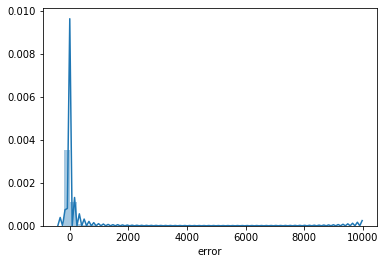

In [87]:
dfy_test['y_pred'] = ptInvert(dfy_test, pipeline.fitted_lambda_target)
dfy_test['error'] = dfy_test['price'] - dfy_test['y_pred']
sns.distplot(dfy_test['error'])
print('Normality: {}'.format(jarque_bera(dfy_test['error'])))
print('Skew value: {}'.format(skew(dfy_test['error'])))
print('{}'.format(skewtest(dfy_test['error'])))

##### Doing some error analysis on the training set

In [88]:
dfy['y_pred'] = ptInvert(dfy, pipeline.fitted_lambda_target)
dfy['error'] = dfy['price'] - dfy['y_pred']

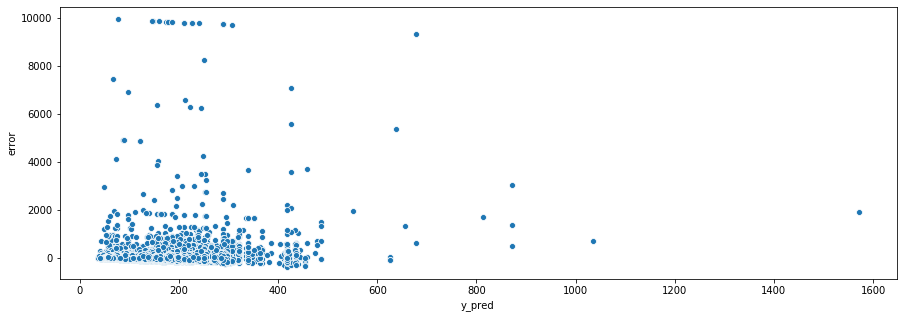

In [89]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=dfy, y='error', x='y_pred')

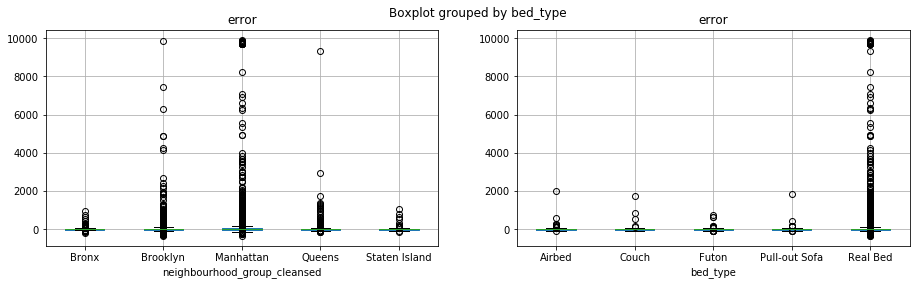

In [90]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
dfy.boxplot(column='error', by='neighbourhood_group_cleansed', ax=ax[0])
dfy.boxplot(column='error', by='bed_type', ax=ax[1])

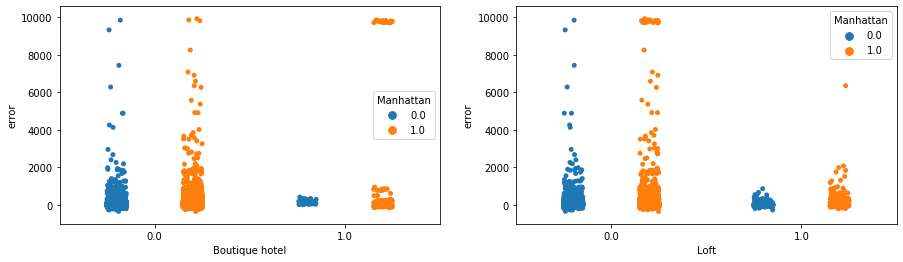

In [91]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
sns.stripplot(data=dfy, y='error', x='Boutique hotel', hue='Manhattan',  dodge=True, ax=ax[0])
sns.stripplot(data=dfy, y='error', x='Loft', hue='Manhattan', dodge=True, ax=ax[1])

In [92]:
del dfy, dfy_test

### Exhaustive Gridsearch

In [19]:
dfy = df_train.copy()
dfy_test = df_test.copy()
kf = KFold(n_folds, shuffle=True, random_state = RANDOM_STATE)
d = {
            'Learning Rate' : [],
            'Max depth' : [],
            'Min child weight' : [],
            'CV RMSE': [], 
            'CV std': [],
            'Training RMSE': [],
            'Training R²' : [],
            'Test RMSE': [], 
            'Test R²' : []}

params = {'max_depth': list(range(2,6)), 'min_child_weight': list(range(2,5)), 'lr': [0.01, 0.05, 0.1]}
for md in params['max_depth']:
    for mcw in params['min_child_weight']:
        for lr in params['lr']:

            xgb_model = XGBRegressor(n_estimators=1000, objective='reg:squarederror', learning_rate=lr, early_stopping=5, max_depth=md, min_child_weight=mcw )            
            cv_res = cross_val_score(xgb_model, dfy[features_ms], dfy['pt_price'], scoring='neg_mean_squared_error', cv=kf)
            xgb_model.fit(dfy[features_ms], dfy['pt_price'])
            y_train_xgb_model = xgb_model.predict(dfy[features_ms])
            y_test_xgb_model = xgb_model.predict(dfy_test[features_ms])
            
            d['Learning Rate'].append(lr)
            d['Max depth'].append(md)
            d['Min child weight'].append(mcw)
            d['CV RMSE'].append(np.sqrt(-cv_res.mean()))
            d['CV std'].append(np.sqrt(cv_res.std()))
            d['Training RMSE'].append(np.expm1(np.sqrt(mean_squared_error(y_train_xgb_model, dfy['pt_price']))))
            d['Training R²'].append(r2_score(dfy['pt_price'], y_train_xgb_model))
            d['Test RMSE'].append(np.expm1(np.sqrt(mean_squared_error(dfy_test['pt_price'], y_test_xgb_model))))
            d['Test R²'].append(r2_score(dfy_test['pt_price'], y_test_xgb_model))

xgb_tuning = pd.DataFrame(d)
xgb_tuning

,Learning Rate,Max depth,Min child weight,CV RMSE,CV std,Training RMSE,Training R²,Test RMSE,Test R²
0,0.010,2,2,0.135,0.021,0.144,0.557,0.146,0.547
1,0.050,2,2,0.131,0.018,0.138,0.593,0.140,0.578
2,0.100,2,2,0.130,0.017,0.135,0.607,0.140,0.580
3,0.010,2,3,0.135,0.020,0.144,0.557,0.146,0.547
4,0.050,2,3,0.131,0.018,0.138,0.593,0.140,0.578
5,0.100,2,3,0.130,0.017,0.136,0.607,0.140,0.581
6,0.010,2,4,0.135,0.020,0.144,0.557,0.146,0.547
7,0.050,2,4,0.131,0.018,0.138,0.593,0.140,0.578
8,0.100,2,4,0.130,0.018,0.136,0.607,0.140,0.583
9,0.010,3,2,0.132,0.019,0.140,0.582,0.142,0.567
